# Dystans na obrazkach + dystans na aktywacjach


In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import keras.backend as K
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D
from keras.layers import MaxPooling2D, Convolution2D
from keras.models import Sequential, model_from_json
from keras.datasets import mnist
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import numpy as np
from tqdm import tqdm_notebook as tqdm

Using TensorFlow backend.


In [2]:
NUM_CLASSES = 10
IMAGE_ROWS = 28
IMAGE_COLS = 28
NUM_CHANNELS = 1

BATCH_SIZE = 100

MODEL_PATH = '/Users/mchrusci/uj/blackbox-attacks/models/modelA'
DRAWINGS_DATASETS_PATH = '/Users/mchrusci/uj/shaper_data/activation-distance/test_targets_drawings_npz/test-targets-drawings-%d.npz'

def load_model():
    print(f'Loading model from {MODEL_PATH}')
    try:
        with open(MODEL_PATH + '.json', 'r') as f:
            json_string = f.read()
            model = model_from_json(json_string)
    except IOError:
        print(f'Failed to read model from json, trying to load mnist model type {type}')
        model = C()

    model.load_weights(MODEL_PATH)
    return model

def C():
    model = Sequential()
    model.add(Convolution2D(64, (5, 5), padding='valid'))
    model.add(Activation('relu'))

    model.add(Convolution2D(64, (5, 5)))
    model.add(Activation('relu'))

    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))

    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES))
    return model

def data_mnist():
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    X_test = X_test.reshape(X_test.shape[0], IMAGE_ROWS, IMAGE_COLS, NUM_CHANNELS)
    X_test = X_test.astype('float32')
    X_test /= 255
    return X_test

def data_drawings(n, num_samples):
    data = np.load(DRAWINGS_DATASETS_PATH % n)
    D = data['drawings'].reshape(-1, IMAGE_ROWS, IMAGE_COLS, NUM_CHANNELS)[0:num_samples]
    T = data['targets'].reshape(-1, IMAGE_ROWS, IMAGE_COLS, NUM_CHANNELS)[0:num_samples]
    return D / 255, T
    
def get_activations(model, layer, data):
    N = data.shape[0]
    
    shape = layer.shape.as_list()
    shape[0] = N
    
    result = np.empty((shape))
    
    num_batches = N // BATCH_SIZE
    
    for i in range(num_batches):
        x = data[i * BATCH_SIZE : i * BATCH_SIZE + BATCH_SIZE]
        r = K.get_session().run([layer], feed_dict={model.input: x, K.learning_phase(): 0})[0]
        result[i * BATCH_SIZE : i * BATCH_SIZE + BATCH_SIZE] = r
        
    return result

def mse(X, Y):
    assert X.shape == Y.shape
    batch_size = 100
    if X.size % batch_size != 0:
        print(f"X.size = {X.size}")
    num_batches = X.shape[0] // batch_size
    
    means = np.empty((num_batches,))
    for i in range(num_batches):
        x = X[i * batch_size : i * batch_size + batch_size]
        y = Y[i * batch_size : i * batch_size + batch_size]
        means[i] = np.mean(np.square(x - y))
    
    return np.mean(means)

In [3]:
model = load_model()
conv1 = model.layers[0].output
conv2 = model.layers[2].output
dense = model.layers[6].output

Loading model from /Users/mchrusci/uj/blackbox-attacks/models/modelA


In [19]:
def plot_activations(layer):
    x = []
    for i in tqdm(range(1, 101)):
        d, t = data_drawings(n=i, num_samples=1000)
        a_d = get_activations(model, layer, d)
        a_t = get_activations(model, layer, t)
        x.append(mse(a_d, a_t))
    plt.plot(x)

Mse na aktywacjach z pierwszej warstwy konwolucyjnej vs liczba akcji (najbardziej przypomina wykres mse na pikselach)

100%|██████████| 100/100 [01:56<00:00,  1.13s/it]


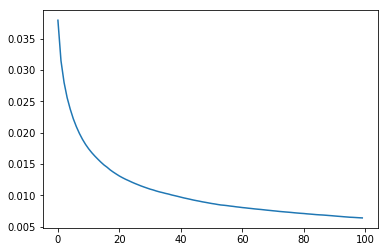

In [21]:
plot_activations(conv1)

Mse na aktywacjach z drugiej warstwy konwolucyjnej vs liczba akcji

100%|██████████| 100/100 [14:17<00:00,  7.98s/it]


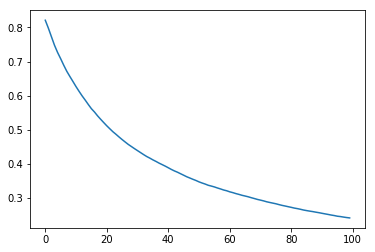

In [20]:
plot_activations(conv2)

Mse na aktywacjach z warstwy FC vs liczba akcji

100%|██████████| 100/100 [13:14<00:00,  7.82s/it]


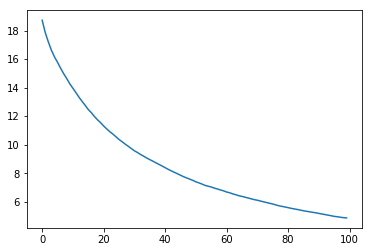

In [5]:
plot_activations(dense)

### Mse

100%|██████████| 100/100 [00:34<00:00,  2.86it/s]


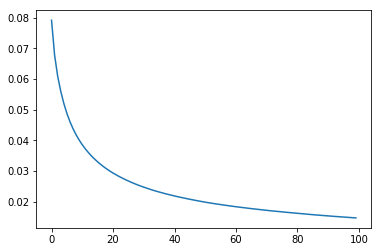

In [34]:
x = []
for i in tqdm(range(1, 101)):
    d, t = data_drawings(n=i)
    x.append(mse(d, t))
plt.plot(x)

### Przykłady rysunków z rewardem po aktywacjach

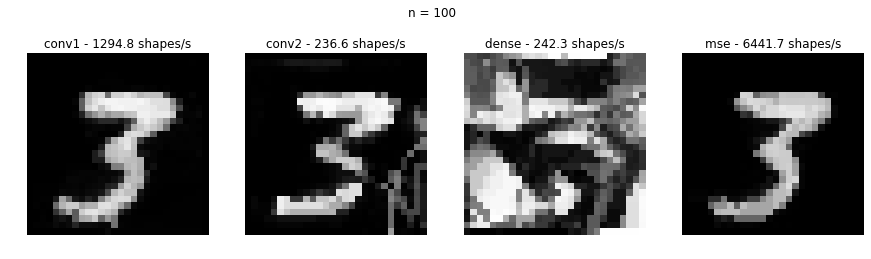

In [20]:
DIR = '/Users/mchrusci/uj/shaper_data/mixed-rewards-examples'
imgs = ['conv1.png', 'conv2.png', 'dense.png', 'mse.png']

fig = plt.figure(figsize=(15,4))
fig.suptitle('n = 100')

plt.subplot(141)
plt.title('conv1 - 1294.8 shapes/s')
plt.axis('off')
plt.imshow(mimg.imread(os.path.join(DIR, imgs[0])))

plt.subplot(142)
plt.title('conv2 - 236.6 shapes/s')
plt.axis('off')
plt.imshow(mimg.imread(os.path.join(DIR, imgs[1])))

plt.subplot(143)
plt.title('dense - 242.3 shapes/s')
plt.axis('off')
plt.imshow(mimg.imread(os.path.join(DIR, imgs[2])))

plt.subplot(144)
plt.title('mse - 6441.7 shapes/s')
plt.axis('off')
plt.imshow(mimg.imread(os.path.join(DIR, imgs[3])))

plt.show()

## Single reward

In [3]:
from es.draw_multiple import draw

default = {"n": 10, "alpha": 0.8, "background": "00"}

def test(configs, title):
    mnist = data_mnist()
    index = np.random.choice(10000)
    sample = mnist[index].reshape(1, mnist.shape[1], mnist.shape[2], mnist.shape[3])
    seed = np.random.randint(1, 1000000)
    
    fig = plt.figure(figsize=(16,3))
    n = configs[0]['n']
    fig.suptitle(f'n = {n}')
                 
    rows = 1
    cols = 6
    
    for i, c in enumerate(configs):
        c['seed'] = seed
        result = draw(sample, **c)
                 
        plt.subplot(rows, cols, i+1)
        plt.title(c[title])
        plt.axis('off')
        plt.imshow(result.reshape(28, 28), cmap='gray')
    
    plt.show()

/Users/mchrusci/uj/shaper/shapes/canvas.py:8: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use("TkAgg")


In [4]:
configs = [{'rewards': 'mse'}, {'rewards': 'l2'}, {'rewards': 'l1'}, {'rewards': 'conv1'}, {'rewards': 'conv2'}, {'rewards': 'dense'}]
[c.update(default) for c in configs]
configs

[{'rewards': 'mse', 'n': 10, 'alpha': 0.8, 'background': '00'},
 {'rewards': 'l2', 'n': 10, 'alpha': 0.8, 'background': '00'},
 {'rewards': 'l1', 'n': 10, 'alpha': 0.8, 'background': '00'},
 {'rewards': 'conv1', 'n': 10, 'alpha': 0.8, 'background': '00'},
 {'rewards': 'conv2', 'n': 10, 'alpha': 0.8, 'background': '00'},
 {'rewards': 'dense', 'n': 10, 'alpha': 0.8, 'background': '00'}]

  0%|          | 0/10 [00:00<?, ?it/s]

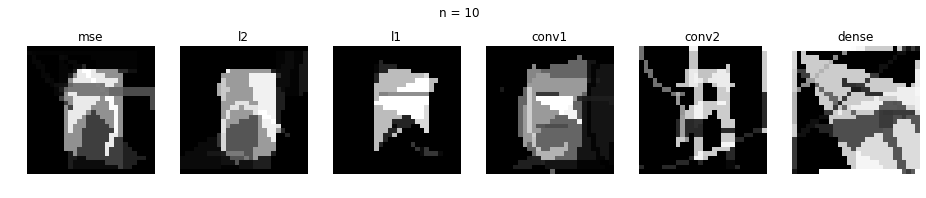

 10%|█         | 1/10 [01:46<16:00, 106.70s/it]

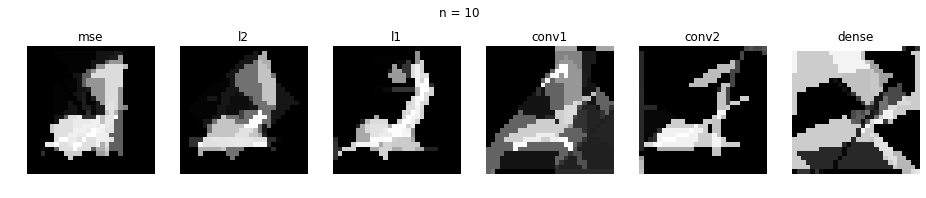

 20%|██        | 2/10 [03:34<14:16, 107.04s/it]

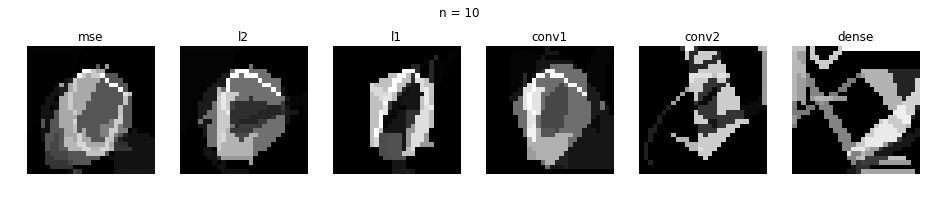

 30%|███       | 3/10 [05:21<12:29, 107.03s/it]

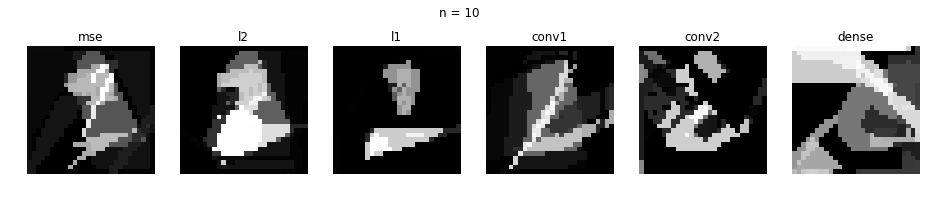

 40%|████      | 4/10 [07:12<10:48, 108.15s/it]

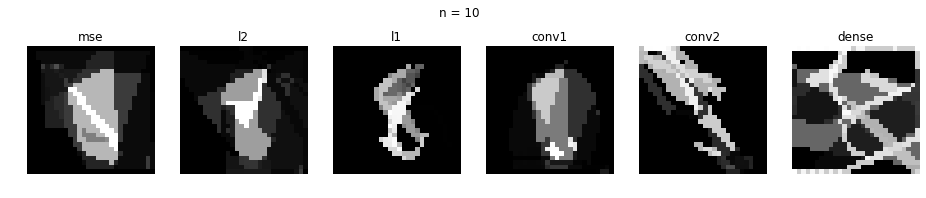

 50%|█████     | 5/10 [09:01<09:02, 108.52s/it]

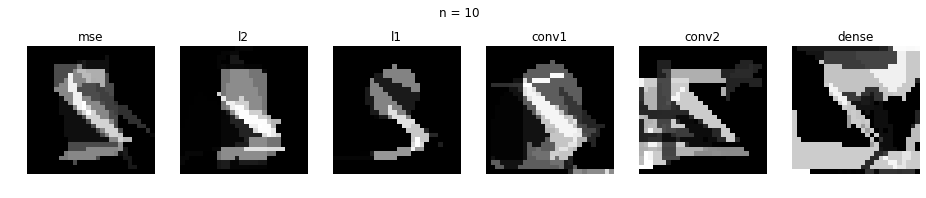

 60%|██████    | 6/10 [10:49<07:13, 108.41s/it]

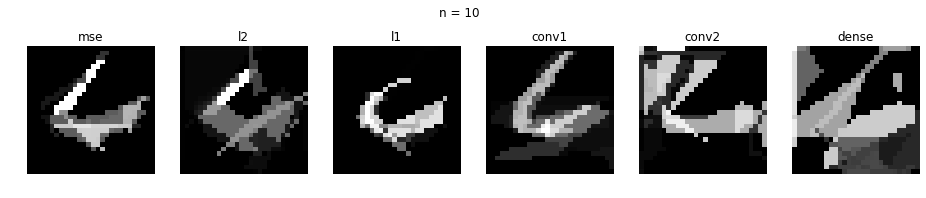

 70%|███████   | 7/10 [12:37<05:24, 108.28s/it]

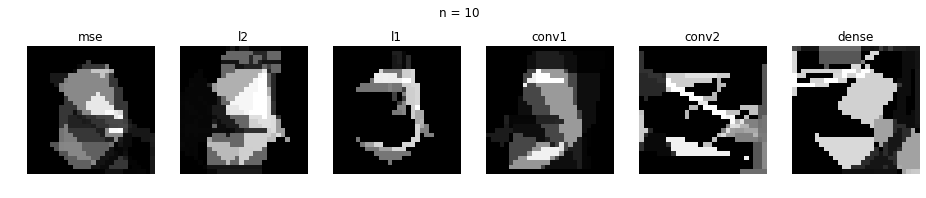

 80%|████████  | 8/10 [14:26<03:36, 108.43s/it]

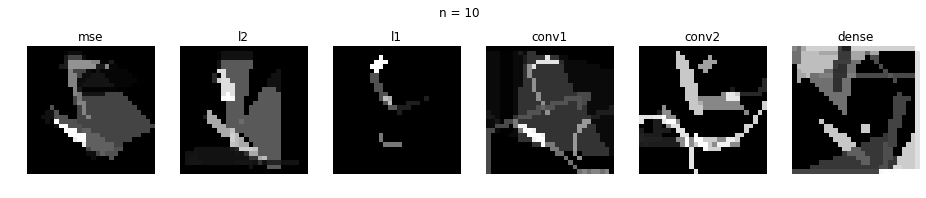

 90%|█████████ | 9/10 [16:17<01:49, 109.32s/it]

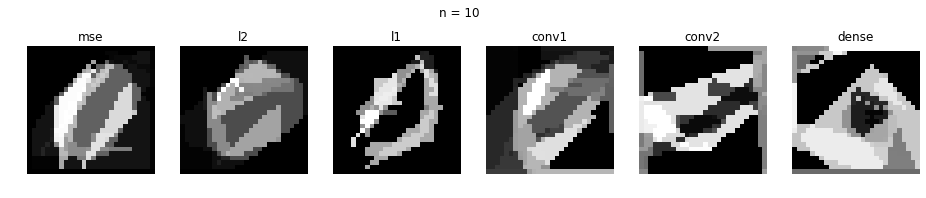

100%|██████████| 10/10 [18:08<00:00, 109.78s/it]


In [5]:
for _ in tqdm(range(10)):
    test(configs)

In [4]:
configs = [{'rewards_coeffs': '1e-6,1'}, {'rewards_coeffs': '1e-5,1'}, {'rewards_coeffs': '1e-4,1'}, {'rewards_coeffs': '1e-3,1'}, {'rewards_coeffs': '1e-2,1'}, {'rewards_coeffs': '1e-1,1'}]
[c.update(default) for c in configs]
[c.update({'rewards': 'mse+conv1'}) for c in configs]
configs

[{'rewards_coeffs': '1e-6,1',
  'n': 10,
  'alpha': 0.8,
  'background': '00',
  'rewards': 'mse+conv1'},
 {'rewards_coeffs': '1e-5,1',
  'n': 10,
  'alpha': 0.8,
  'background': '00',
  'rewards': 'mse+conv1'},
 {'rewards_coeffs': '1e-4,1',
  'n': 10,
  'alpha': 0.8,
  'background': '00',
  'rewards': 'mse+conv1'},
 {'rewards_coeffs': '1e-3,1',
  'n': 10,
  'alpha': 0.8,
  'background': '00',
  'rewards': 'mse+conv1'},
 {'rewards_coeffs': '1e-2,1',
  'n': 10,
  'alpha': 0.8,
  'background': '00',
  'rewards': 'mse+conv1'},
 {'rewards_coeffs': '1e-1,1',
  'n': 10,
  'alpha': 0.8,
  'background': '00',
  'rewards': 'mse+conv1'}]

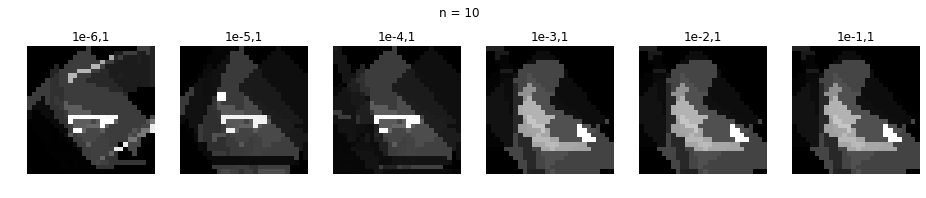

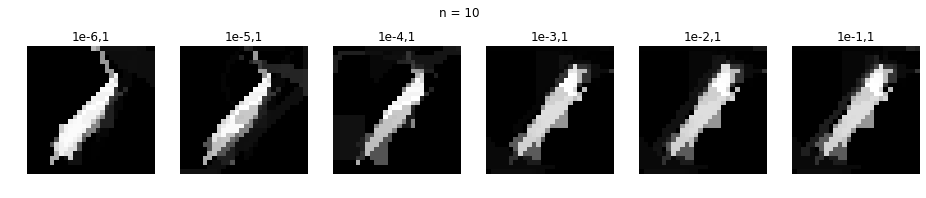

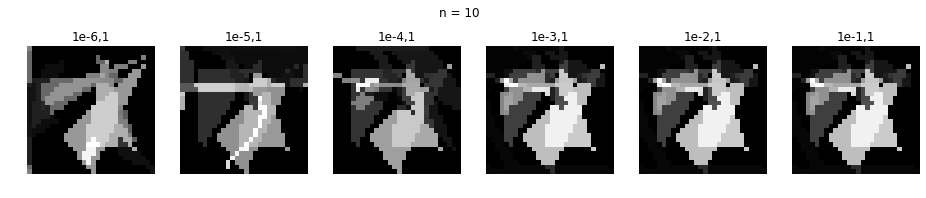

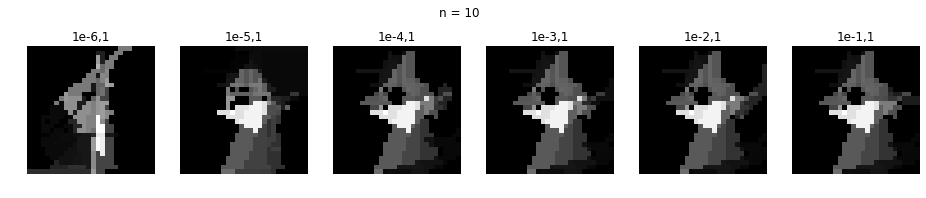

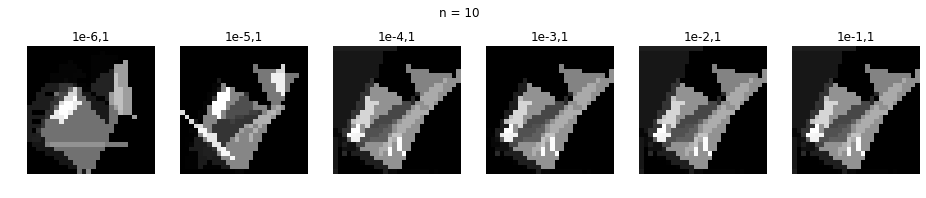

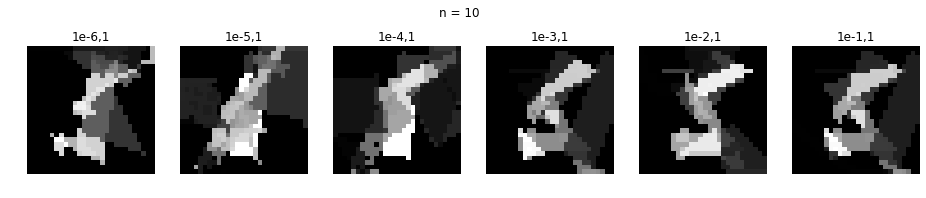

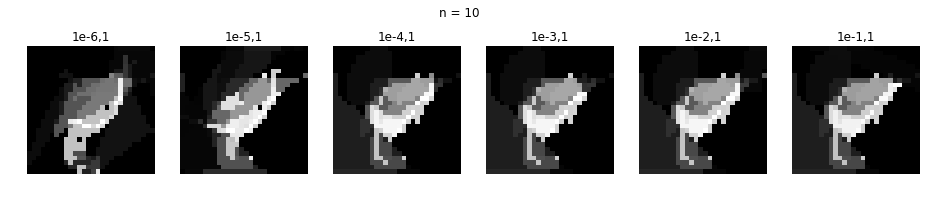

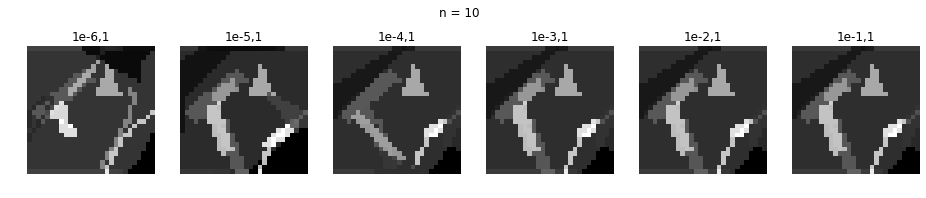

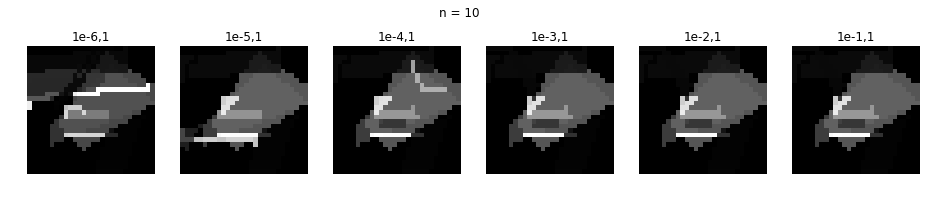

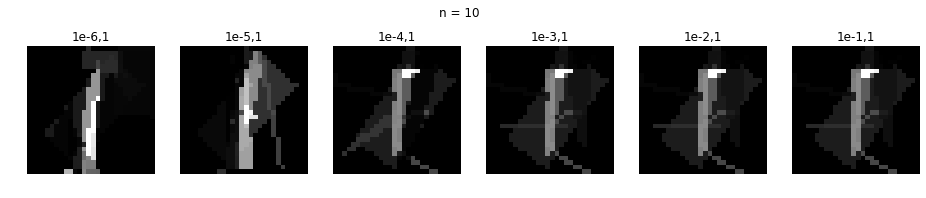

In [5]:
for _ in tqdm(range(10)):
    test(configs, title='rewards_coeffs')

In [6]:
configs = [{'rewards_coeffs': '1e-6,1'}, {'rewards_coeffs': '1e-5,1'}, {'rewards_coeffs': '1e-4,1'}, {'rewards_coeffs': '1e-3,1'}, {'rewards_coeffs': '1e-2,1'}, {'rewards_coeffs': '1e-1,1'}]
[c.update(default) for c in configs]
[c.update({'rewards': 'mse+conv1'}) for c in configs]
[c.update({'alpha': 0.6}) for c in configs]
[c.update({'background': None}) for c in configs]
configs

[{'rewards_coeffs': '1e-6,1',
  'n': 10,
  'alpha': 0.6,
  'background': None,
  'rewards': 'mse+conv1'},
 {'rewards_coeffs': '1e-5,1',
  'n': 10,
  'alpha': 0.6,
  'background': None,
  'rewards': 'mse+conv1'},
 {'rewards_coeffs': '1e-4,1',
  'n': 10,
  'alpha': 0.6,
  'background': None,
  'rewards': 'mse+conv1'},
 {'rewards_coeffs': '1e-3,1',
  'n': 10,
  'alpha': 0.6,
  'background': None,
  'rewards': 'mse+conv1'},
 {'rewards_coeffs': '1e-2,1',
  'n': 10,
  'alpha': 0.6,
  'background': None,
  'rewards': 'mse+conv1'},
 {'rewards_coeffs': '1e-1,1',
  'n': 10,
  'alpha': 0.6,
  'background': None,
  'rewards': 'mse+conv1'}]

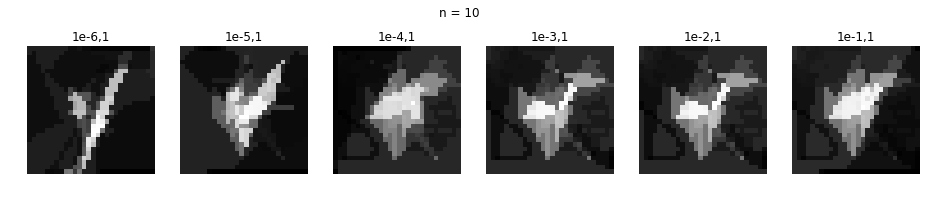

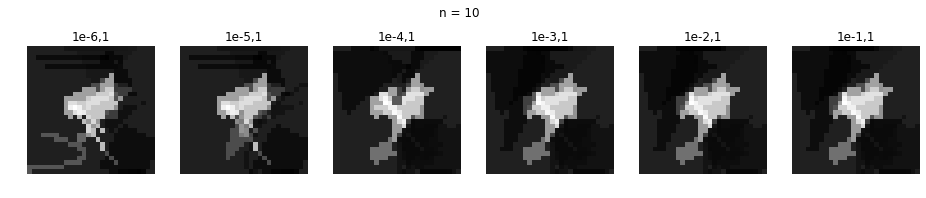

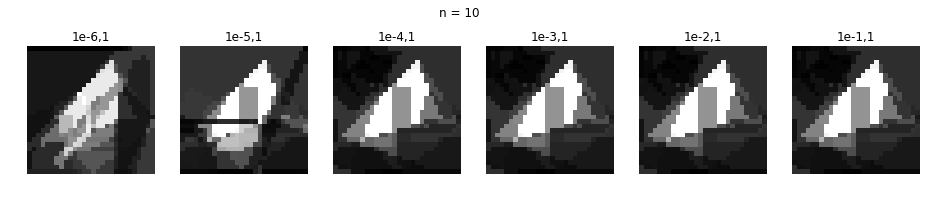

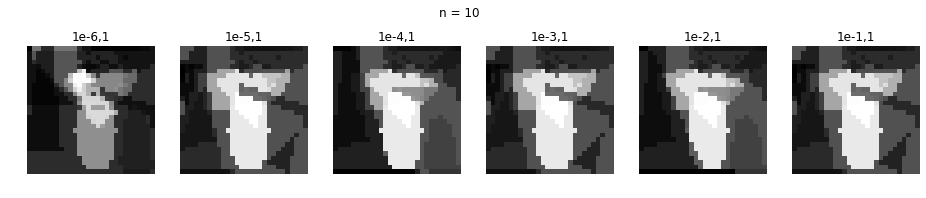

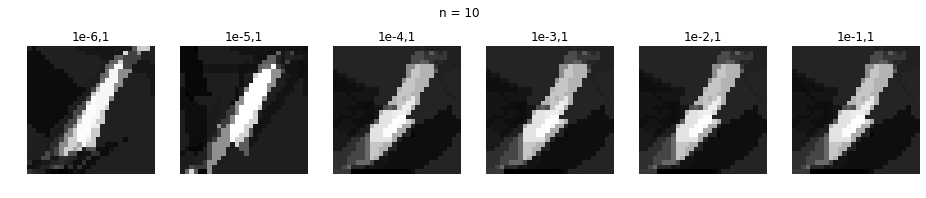

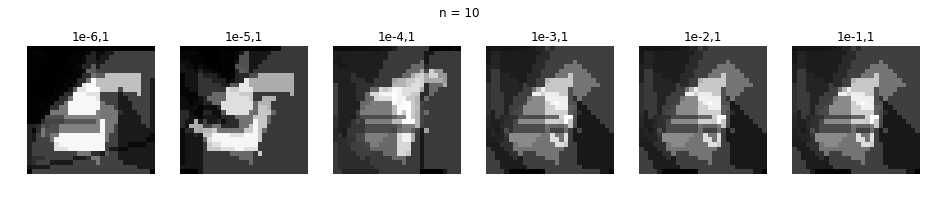

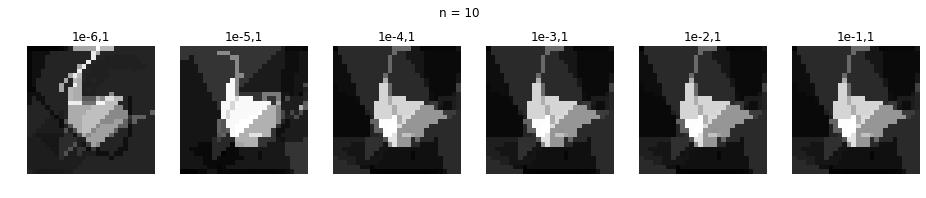

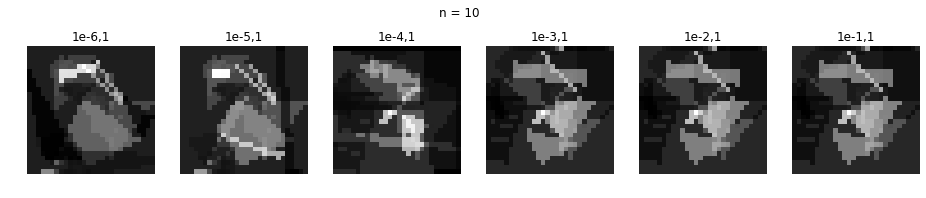

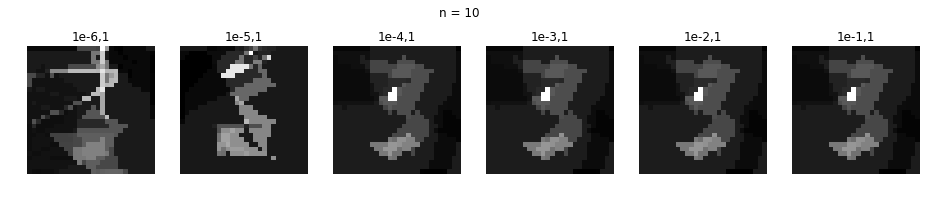

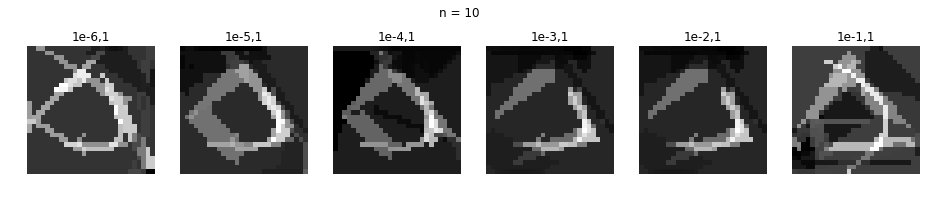

In [7]:
for _ in tqdm(range(10)):
    test(configs, title='rewards_coeffs')